## Part II: Predicting Hall of Fame Careers

# Try the model without using cross val predict.  Split into train and test like in part I to get the model right... then figure out cross val predict.

In [2697]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [2698]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryFielding = 'select * from Fielding;'
queryAwards = 'select playerID,awardID,yearID from AwardsPlayers;'
queryAllStar = 'select playerID, YearID from AllstarFull;'
queryHOF = '''select playerID,yearid,votedBy,needed_note from HallofFame where 
inducted == "Y" and category == "Player";'''

In [2699]:
batting_df = pd.read_csv('Batting.csv')

In [2700]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
awards = conn.execute(queryAwards).fetchall()
awards_df = pd.DataFrame(awards)
allstar = conn.execute(queryAllStar).fetchall()
allstar_df = pd.DataFrame(allstar)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)

In [2701]:
master_cols = ['playerID','nameFirst','nameLast','bats','throws','debut','finalGame']
master_df.columns = master_cols

fielding_cols = ['playerID','yearID','stint','teamID','lgID','Pos','G','GS','InnOuts','PO','A','E','DP','PB','WP','SB','CS','ZR']
fielding_df.columns = fielding_cols

awards_cols = ['playerID','awardID','yearID']
awards_df.columns = awards_cols

allstar_cols = ['playerID','YearID']
allstar_df.columns = allstar_cols

hof_cols = ['playerID','yearid','votedBy','needed_note']
hof_df.columns = hof_cols

In [2702]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [2703]:
player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + SF
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['SF'] = SF
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [2704]:
eras_played = {}
for k, v in years_played.items():
    eras_played[k] = {}
    player_stats[k]['Years_Played'] = len(list(set(v)))
    for year in v:
        if year < 1920:
            eras_played[k]['pre1920'] = 1
        elif year >= 1920 and year <= 1941:
            eras_played[k]['1920-41'] = 1
        elif year >= 1942 and year <= 1945:
            eras_played[k]['1942-45'] = 1
        elif year >= 1946 and year <= 1962:
            eras_played[k]['1946-62'] = 1
        elif year >= 1963 and year <= 1976:
            eras_played[k]['1963-76'] = 1
        elif year >= 1977 and year <= 1992:
            eras_played[k]['1977-92'] = 1
        elif year >= 1993 and year <= 2009:
            eras_played[k]['1993-2009'] = 1

In [2705]:
eras_df = pd.DataFrame.from_dict(eras_played, orient='index')

## Add in years played and eras played in.

In [2706]:
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    PBfc = row['PB']
    WPfc = row['WP']
    SBfc = row['SB']
    CSfc = row['CS']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
        player_stats[playerID]['PBfc'] = player_stats[playerID]['PBfc'] + PBfc
        player_stats[playerID]['WPfc'] = player_stats[playerID]['WPfc'] + WPfc
        player_stats[playerID]['SBfc'] = player_stats[playerID]['SBfc'] + SBfc
        player_stats[playerID]['CSfc'] = player_stats[playerID]['CSfc'] + CSfc
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf
        player_stats[playerID]['PBfc'] = PBfc
        player_stats[playerID]['WPfc'] = WPfc
        player_stats[playerID]['SBfc'] = SBfc
        player_stats[playerID]['CSfc'] = CSfc

In [2707]:
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [2708]:
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']
ws_mvp_df = awards_df[awards_df['awardID'] == 'World Series MVP']
awards_list = [mvp_df,roy_df,gg_df,ss_df,ws_mvp_df]

In [2709]:
print(awards_list[1].head())

       playerID             awardID  yearID
1796  robinja02  Rookie of the Year    1947
1845   darkal01  Rookie of the Year    1948
1899  sievero01  Rookie of the Year    1949
1900  newcodo01  Rookie of the Year    1949
1953  dropowa01  Rookie of the Year    1950


In [2710]:
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
ws_mvp_list = []
lists = [mvp_list,roy_list,gg_list,ss_list,ws_mvp_list]

In [2711]:
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [2712]:
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [2713]:
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1
        player_stats[playerID]['votedBy'] = row['votedBy']

In [2714]:
print(len(hof_df))
print(len(master_df))

250
19105


In [2715]:
print(dict(list(player_stats.items())[0:2]))

{'finlebi01': {'AB': 44, 'CS': nan, 'RBI': 5.0, 'DPf': 1.0, 'SO': 8.0, 'GSf': nan, 'H': 8, 'Af': 10.0, 'HBP': nan, 'InnOutsf': nan, 'SB': 2.0, 'R': 2, 'POf': 29, 'SH': nan, 'IBB': nan, 'SF': nan, 'GIDP': nan, '3B': 0, '2B': 0, 'CSfc': nan, 'WPfc': nan, 'Gf': 16, 'G': 13, 'HR': 0, 'SBfc': nan, 'Years_Played': 1, 'BB': 1, 'PBfc': nan, 'Ef': 5.0}, 'burkebi02': {'AB': 22, 'CS': nan, 'RBI': 1.0, 'DPf': 0.0, 'SO': 8.0, 'GSf': nan, 'H': 5, 'Af': 11.0, 'HBP': 0.0, 'InnOutsf': nan, 'SB': 0.0, 'R': 1, 'POf': 6, 'SH': 1.0, 'IBB': nan, 'SF': nan, 'GIDP': nan, '3B': 0, '2B': 1, 'CSfc': nan, 'WPfc': nan, 'Gf': 21, 'G': 22, 'HR': 0, 'SBfc': nan, 'Years_Played': 2, 'BB': 0, 'PBfc': nan, 'Ef': 3.0}}


In [2716]:
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')
stats_df['playerID'] = stats_df.index
print(stats_df.head())
print(master_df.head())

              AB    CS     RBI    DPf      SO     GSf     H     Af   HBP  \
aardsda01      4   0.0     0.0    2.0     2.0     0.0     0   29.0   0.0   
aaronha01  12364  73.0  2297.0  218.0  1383.0  2977.0  3771  429.0  32.0   
aaronto01    944   8.0    94.0  124.0   145.0   206.0   216  113.0   0.0   
aasedo01       5   0.0     0.0   10.0     3.0    91.0     0  135.0   0.0   
abadan01      21   1.0     0.0    3.0     5.0     4.0     2    1.0   0.0   

           InnOutsf    ...         Ef  Gold Glove  AS_games  \
aardsda01    1011.0    ...        3.0         NaN       NaN   
aaronha01   78413.0    ...      144.0         3.0      25.0   
aaronto01    6472.0    ...       22.0         NaN       NaN   
aasedo01     3328.0    ...       13.0         NaN       1.0   
abadan01      138.0    ...        1.0         NaN       NaN   

           Rookie of the Year  Most Valuable Player  HoF  votedBy  \
aardsda01                 NaN                   NaN  NaN      NaN   
aaronha01                 

In [2717]:
master_df = master_df.join(stats_df,on='playerID',how='inner',rsuffix='mstr')

In [2718]:
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
        
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

In [2719]:
pos_list = []
pos_dict = {}
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    games = row['G']
    pos = row['Pos']
    if playerID in pos_dict:
        if pos in pos_dict[playerID]:
            pos_dict[playerID][pos] = pos_dict[playerID][pos] + games
        else:
            pos_dict[playerID][pos] = games
    else:
        pos_dict[playerID] = {}
        pos_dict[playerID][pos] = games

In [2720]:
primary_pos_dict = {}
player_list = []
for k, v in pos_dict.items():
    playerID = k
    primary_pos_dict[playerID] = {}
    primary_pos_dict[playerID]['game_count'] = 0
    primary_pos_dict[playerID]['game_count2'] = 0
    primary_pos_dict[playerID]['pos'] = ''
    for key, val in v.items():      
        if val > primary_pos_dict[playerID]['game_count']:
            primary_pos_dict[playerID]['pos2'] = primary_pos_dict[playerID]['pos']
            primary_pos_dict[playerID]['pos'] = key
            primary_pos_dict[playerID]['game_count2'] = primary_pos_dict[playerID]['game_count']
            primary_pos_dict[playerID]['game_count'] = val

In [2721]:
primary_pos_df = pd.DataFrame.from_dict(primary_pos_dict, orient='index')
primary_pos_df = primary_pos_df.drop(['game_count','game_count2'], axis=1)
primary_pos_df = primary_pos_df[(primary_pos_df['pos'] != 'P') & (primary_pos_df['pos'] != 'C')]

In [2722]:
def infield(pos):
    if pos == '1B':
        return 1
    if pos == '2B':
        return 1
    if pos == '3B':
        return 1
    if pos == 'SS':
        return 1
    else:
        return 0
    
primary_pos_df['infielder'] = primary_pos_df['pos'].apply(infield)
master_df = master_df.join(primary_pos_df,on='playerID',how='right')

In [2723]:
dummy_df = pd.get_dummies(master_df['pos'], prefix='pos_')
master_df = pd.concat([master_df, dummy_df], axis=1)

In [2724]:
master_df['votedBy'] = master_df['votedBy'].fillna('None')
master_df = master_df[(master_df['votedBy'] == 'None') | (master_df['votedBy'] == 'BBWAA') | (master_df['votedBy'] == 'Run Off')]

In [2725]:
print(master_df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'debut',
       'finalGame', 'AB', 'CS', 'RBI', 'DPf', 'SO', 'GSf', 'H', 'Af', 'HBP',
       'InnOutsf', 'SB', 'R', 'POf', 'SH', 'IBB', 'SF', 'GIDP', '3B', '2B',
       'CSfc', 'WPfc', 'Gf', 'G', 'HR', 'SBfc', 'Years_Played', 'BB', 'PBfc',
       'Ef', 'Gold Glove', 'AS_games', 'Rookie of the Year',
       'Most Valuable Player', 'HoF', 'votedBy', 'Silver Slugger',
       'World Series MVP', 'playerIDmstr', 'bats_R', 'throws_R', 'pos', 'pos2',
       'infielder', 'pos__1B', 'pos__2B', 'pos__3B', 'pos__OF', 'pos__SS'],
      dtype='object')


In [2726]:
# Eliminating unnecessary columns
df = master_df.drop(['votedBy', 'CS', 'IBB', 'bats', 'throws','GIDP','GSf','CSfc', 'POf','Gf', 'PBfc', 'WPfc','InnOutsf', 'SBfc', 'SH', 'playerIDmstr', 'pos'], axis=1)

In [2727]:
from datetime import datetime
df['debut'] =  pd.to_datetime(df['debut'])
df['finalGame'] = pd.to_datetime(df['finalGame'])
df['debutYear'] = pd.to_numeric(df['debut'].dt.strftime('%Y'), errors='coerce')
df['finalYear'] = pd.to_numeric(df['finalGame'].dt.strftime('%Y'), errors='coerce')
df = df.join(eras_df,on='playerID',how='inner')

In [2728]:
print(df.columns)
print(df.isnull().sum(axis=0).tolist())

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'AB', 'RBI',
       'DPf', 'SO', 'H', 'Af', 'HBP', 'SB', 'R', 'SF', '3B', '2B', 'G', 'HR',
       'Years_Played', 'BB', 'Ef', 'Gold Glove', 'AS_games',
       'Rookie of the Year', 'Most Valuable Player', 'HoF', 'Silver Slugger',
       'World Series MVP', 'bats_R', 'throws_R', 'pos2', 'infielder',
       'pos__1B', 'pos__2B', 'pos__3B', 'pos__OF', 'pos__SS', 'debutYear',
       'finalYear', 'pre1920', '1977-92', '1993-2009', '1946-62', '1942-45',
       '1963-76', '1920-41'],
      dtype='object')
[0, 28, 0, 2, 2, 0, 213, 1, 1359, 0, 1, 653, 315, 0, 4043, 0, 0, 0, 0, 0, 0, 1, 7308, 6747, 7465, 7449, 7479, 7323, 7523, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 5161, 6114, 5818, 6503, 7064, 6492, 6265]


In [2729]:
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year', 'Gold Glove', 'Most Valuable Player', 'HoF',
'1977-92', 'pre1920', '1942-45', '1946-62', '1963-76', '1920-41', '1993-2009', 'HBP', 'SB', 'SF', 'RBI', 'SO', 'World Series MVP']

for col in fill_cols:
    df[col] = df[col].fillna(0)
    
print(df.isnull().sum(axis=0).tolist())

[0, 28, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0]


In [2730]:
# Eliminating rows with null values
df = df.dropna()
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [2731]:
df_hof = df[df['HoF'] == 1]
print(len(df_hof))

71


In [2732]:
df['YSR'] = 2016 - df['finalYear']

In [2733]:
df['AVE'] = df['H'] / df['AB']
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

In [2734]:
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['OPS'] = ((df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])) + ((single + double + triple + hr)/ df['AB'])

In [2735]:
df_hitters = df[df['YSR'] > 15]
df_eligable = df[df['YSR']<= 15]

In [2736]:
df_hitters = df_hitters[(df_hitters['playerID'] != 'johnswa01') & (df_hitters['playerID'] != 'lemonbo01') & 
(df_hitters['playerID'] != 'lyonste01') & (df_hitters['playerID'] != 'mathech01') & (df_hitters['playerID'] != 'ruffire01') &
(df_hitters['playerID'] != 'alexape01') & (df_hitters['playerID'] != 'robinja02')]

In [2737]:
print(len(df_hitters))

6327


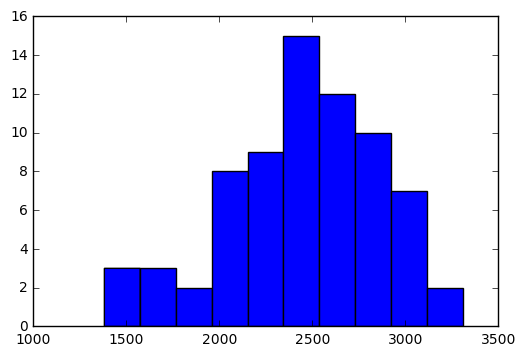

In [2738]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_hof['G'])
plt.show()

In [2739]:
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'AB', 'RBI',
       'DPf', 'SO', 'H', 'Af', 'HBP', 'SB', 'R', 'SF', '3B', '2B', 'G', 'HR',
       'Years_Played', 'BB', 'Ef', 'Gold Glove', 'AS_games',
       'Rookie of the Year', 'Most Valuable Player', 'HoF', 'Silver Slugger',
       'World Series MVP', 'bats_R', 'throws_R', 'pos2', 'infielder',
       'pos__1B', 'pos__2B', 'pos__3B', 'pos__OF', 'pos__SS', 'debutYear',
       'finalYear', 'pre1920', '1977-92', '1993-2009', '1946-62', '1942-45',
       '1963-76', '1920-41', 'YSR', 'AVE', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [2740]:
num_cols_hitters = ['playerID', 'nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE', 'OBP', 'Slug_Percent', 'OPS',  'RBI',
       'R', 'SB',  '2B', '3B', 'G', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef','pos__1B', 'pos__2B', 
       'pos__3B', 'pos__SS', 'infielder', 'pos__OF', 'YSR', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009']
data = df_hitters[num_cols_hitters]

In [2741]:
print(data.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB',
       'HR', 'AVE', 'OBP', 'Slug_Percent', 'OPS', 'RBI', 'R', 'SB', '2B', '3B',
       'G', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger', 'bats_R',
       'throws_R', 'DPf', 'Af', 'Ef', 'pos__1B', 'pos__2B', 'pos__3B',
       'pos__SS', 'infielder', 'pos__OF', 'YSR', 'pre1920', '1920-41',
       '1942-45', '1946-62', '1963-76', '1977-92', '1993-2009'],
      dtype='object')


In [2742]:
print(data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 32, 30, 32, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [2743]:
# Eliminating rows with null values
data = data.dropna()

In [2744]:
print(len(data))

6295


In [2745]:
data_hof = data[data['HoF'] == 1]
print(len(data_hof))

60


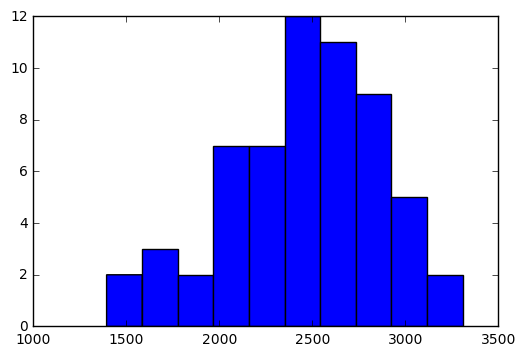

In [2746]:
plt.hist(data_hof['G'])
plt.show()

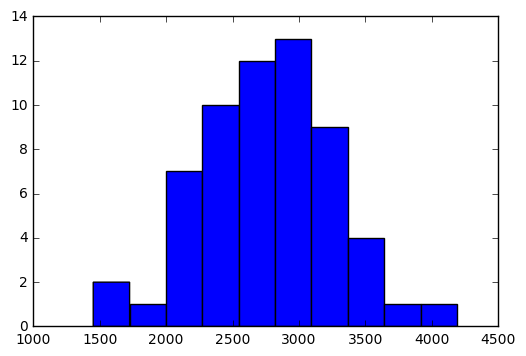

In [2747]:
plt.hist(data_hof['H'])
plt.show()

In [2748]:
print(data_hof.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB',
       'HR', 'AVE', 'OBP', 'Slug_Percent', 'OPS', 'RBI', 'R', 'SB', '2B', '3B',
       'G', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger', 'bats_R',
       'throws_R', 'DPf', 'Af', 'Ef', 'pos__1B', 'pos__2B', 'pos__3B',
       'pos__SS', 'infielder', 'pos__OF', 'YSR', 'pre1920', '1920-41',
       '1942-45', '1946-62', '1963-76', '1977-92', '1993-2009'],
      dtype='object')


In [2749]:
target = data['HoF']
features = data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

## Don't forget to deal with class imbalance.

In [2750]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
kf = KFold(features.shape[0], random_state=1)

predictions_lr = cross_val_predict(lr, features, target, cv=kf)
predictions_lr = pd.Series(predictions_lr)

In [2751]:
np_predictions_lr = predictions_lr.as_matrix()
np_target = data['HoF'].as_matrix()

In [2752]:
tn_filter_lr = (np_predictions_lr == 0) & (np_target == 0)
tn_lr = len(np_predictions_lr[tn_filter_lr])

tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

In [2753]:
print(tn_lr)
print(tp_lr)
print(fn_lr)
print(fp_lr)
tnr_lr = tn_lr / (tn_lr + fp_lr)
tpr_lr = tp_lr / (tp_lr + fn_lr)
fnr_lr = fn_lr / (fn_lr + tp_lr)
fpr_lr = fp_lr / (fp_lr + tn_lr)


print(tpr_lr)
print(fpr_lr)

print(tnr_lr)
print(fnr_lr)

6201
52
8
34
0.8666666666666667
0.00545308740978348
0.9945469125902165
0.13333333333333333


In [2754]:
from sklearn.ensemble import RandomForestClassifier

penalty = {
    0: 50,
    1: 1
}

rf = RandomForestClassifier(random_state=1,n_estimators=11, max_depth=10, min_samples_leaf=1, class_weight=penalty)
predictions_rf = cross_val_predict(rf, features, target, cv=kf)
predictions_rf = pd.Series(predictions_rf)

In [2755]:
print(len(predictions_rf))
print(len(data['HoF']))

6295
6295


In [2756]:
np_predictions_rf = predictions_rf.as_matrix()

In [2757]:
tn_filter_rf = (np_predictions_rf == 0) & (np_target == 0)
tn_rf = len(np_predictions_rf[tn_filter_rf])

tp_filter_rf = (np_predictions_rf == 1) & (np_target == 1)
tp_rf = len(np_predictions_rf[tp_filter_rf])

fn_filter_rf = (np_predictions_rf == 0) & (np_target == 1)
fn_rf = len(np_predictions_rf[fn_filter_rf])

fp_filter_rf = (np_predictions_rf == 1) & (np_target == 0)
fp_rf = len(np_predictions_rf[fp_filter_rf])

In [2758]:
print(tn_rf)
print(tp_rf)
print(fn_rf)
print(fp_rf)

6229
50
10
6


In [2759]:
tnr_rf = tn_rf / (tn_rf + fp_rf)
tpr_rf = tp_rf / (tp_rf + fn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)
fpr_rf = fp_rf / (fp_rf + tn_rf)

In [2760]:
print(tpr_rf)
print(tnr_rf)
print(fpr_rf)
print(fnr_rf)

0.8333333333333334
0.999037690457097
0.0009623095429029671
0.16666666666666666


In [2761]:
new_data = df_eligable[num_cols_hitters]
print(new_data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [2762]:
print(df_eligable.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'AB', 'RBI',
       'DPf', 'SO', 'H', 'Af', 'HBP', 'SB', 'R', 'SF', '3B', '2B', 'G', 'HR',
       'Years_Played', 'BB', 'Ef', 'Gold Glove', 'AS_games',
       'Rookie of the Year', 'Most Valuable Player', 'HoF', 'Silver Slugger',
       'World Series MVP', 'bats_R', 'throws_R', 'pos2', 'infielder',
       'pos__1B', 'pos__2B', 'pos__3B', 'pos__OF', 'pos__SS', 'debutYear',
       'finalYear', 'pre1920', '1977-92', '1993-2009', '1946-62', '1942-45',
       '1963-76', '1920-41', 'YSR', 'AVE', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [2763]:
new_data = new_data.dropna()
new_features = new_data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

In [2764]:
rf.fit(features, target)
probabilities = rf.predict_proba(new_features)

In [2766]:
hof_predictions = pd.DataFrame(probabilities[:,1])

In [2767]:
hof_predictions = hof_predictions.sort_values(0,ascending=False)

In [2776]:
print(hof_predictions.head(50))

             0
938   1.000000
883   1.000000
582   1.000000
82    1.000000
83    1.000000
48    1.000000
898   1.000000
606   1.000000
1034  1.000000
829   1.000000
455   1.000000
1077  1.000000
1078  1.000000
732   1.000000
472   1.000000
818   1.000000
113   1.000000
1008  1.000000
168   0.909173
98    0.909091
636   0.909091
565   0.909091
46    0.909091
501   0.909091
285   0.909091
926   0.909091
434   0.818461
500   0.818461
459   0.818264
1131  0.818182
1058  0.818182
5     0.727592
270   0.636404
20    0.545774
433   0.545534
734   0.545455
387   0.454824
405   0.454712
946   0.454668
180   0.454624
700   0.367342
892   0.363915
360   0.363915
809   0.363798
316   0.363637
662   0.273208
616   0.273006
1134  0.272936
945   0.272935
580   0.272728


In [2777]:
for i, row in hof_predictions.head(50).iterrows():
    print(new_data.iloc[i,1:28])

nameFirst                    Alex
nameLast                Rodriguez
HoF                             0
Years_Played                   22
H                            3115
BB                           1338
HR                            696
AVE                      0.294814
OBP                      0.374076
Slug_Percent             0.550161
OPS                      0.929867
RBI                          2086
R                            2021
SB                            329
2B                            548
3B                             31
G                            2784
AB                          10566
SO                           2287
Most Valuable Player            3
World Series MVP                0
AS_games                       14
Gold Glove                      2
Rookie of the Year              0
Silver Slugger                 10
bats_R                          1
throws_R                        1
Name: 14668, dtype: object
nameFirst                 Albert
nameLast              